In [1]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

In [2]:
import logging
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.datasets.utils import load_karate_graph
from geomstats.geometry.poincare_ball import PoincareBall

INFO: Using numpy backend


In [3]:
gs.random.seed(1234)
dim = 2
max_epochs = 100
lr = .05
n_negative = 2
context_size = 1
karate_graph = load_karate_graph()

In [4]:
nb_vertices_by_edges =\
    [len(e_2) for _, e_2 in karate_graph.edges.items()]
logging.info('Number of vertices: %s', len(karate_graph.edges))
logging.info(
    'Mean edge-vertex ratio: %s',
    (sum(nb_vertices_by_edges, 0) / len(karate_graph.edges)))


INFO: Number of vertices: 34
INFO: Mean edge-vertex ratio: 4.588235294117647


In [5]:
hyperbolic_manifold = PoincareBall(2)

In [6]:
def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    hyperbolic_metric = PoincareBall(2).metric
    log_map = hyperbolic_metric.log(point_b, point_a)

    return -2 * log_map

In [7]:
def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))

In [8]:
def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))

In [9]:
def loss(example_embedding, context_embedding, negative_embedding,
         manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim =\
        negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)
    positive_distance =\
        manifold.metric.squared_dist(
            example_embedding, context_embedding)
    positive_loss =\
        log_sigmoid(-positive_distance)

    reshaped_example_embedding =\
        gs.repeat(example_embedding, n_edges, axis=0)
    negative_distance =\
        manifold.metric.squared_dist(
            reshaped_example_embedding, negative_embedding)
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad =\
        -grad_log_sigmoid(-positive_distance)

    positive_distance_grad =\
        grad_squared_distance(example_embedding, context_embedding)

    positive_grad =\
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1)\
        * positive_distance_grad

    negative_distance_grad =\
        grad_squared_distance(reshaped_example_embedding, negative_embedding)

    negative_distance = gs.to_ndarray(negative_distance,
                                      to_ndim=2, axis=-1)
    negative_log_sigmoid_grad =\
        grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad\
        * negative_distance_grad
    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad

In [10]:
embeddings = gs.random.normal(size=(karate_graph.n_nodes, dim))
embeddings = embeddings * 0.2

In [11]:
random_walks = karate_graph.random_walk()

In [12]:
negative_table_parameter = 5
negative_sampling_table = []

for i, nb_v in enumerate(nb_vertices_by_edges):
    negative_sampling_table +=\
        ([i] * int((nb_v**(3. / 4.))) * negative_table_parameter)

negative_sampling_table = gs.array(negative_sampling_table)

In [13]:
for epoch in range(max_epochs):
    total_loss = []
    for path in random_walks:

        for example_index, one_path in enumerate(path):
            context_index = path[max(0, example_index - context_size):
                                 min(example_index + context_size,
                                 len(path))]
            negative_index =\
                gs.random.randint(negative_sampling_table.shape[0],
                                  size=(len(context_index),
                                  n_negative))
            negative_index = negative_sampling_table[negative_index]

            example_embedding = embeddings[one_path]
            for one_context_i, one_negative_i in zip(context_index,
                                                     negative_index):
                context_embedding = embeddings[one_context_i]
                negative_embedding = embeddings[one_negative_i]
                l, g_ex = loss(
                    example_embedding,
                    context_embedding,
                    negative_embedding,
                    hyperbolic_manifold)
                total_loss.append(l)

                example_to_update = embeddings[one_path]
                embeddings[one_path] = hyperbolic_manifold.metric.exp(
                    -lr * g_ex, example_to_update)
    logging.info(
        'iteration %d loss_value %f',
        epoch, sum(total_loss, 0) / len(total_loss))

INFO: iteration 0 loss_value 1.860523
INFO: iteration 1 loss_value 1.800217
INFO: iteration 2 loss_value 1.731612
INFO: iteration 3 loss_value 1.667285
INFO: iteration 4 loss_value 1.637948
INFO: iteration 5 loss_value 1.607282
INFO: iteration 6 loss_value 1.560220
INFO: iteration 7 loss_value 1.492660
INFO: iteration 8 loss_value 1.474845
INFO: iteration 9 loss_value 1.418243
INFO: iteration 10 loss_value 1.373060
INFO: iteration 11 loss_value 1.383301
INFO: iteration 12 loss_value 1.342917
INFO: iteration 13 loss_value 1.350228
INFO: iteration 14 loss_value 1.315000
INFO: iteration 15 loss_value 1.323195
INFO: iteration 16 loss_value 1.299895
INFO: iteration 17 loss_value 1.298796
INFO: iteration 18 loss_value 1.308219
INFO: iteration 19 loss_value 1.288793
INFO: iteration 20 loss_value 1.295942
INFO: iteration 21 loss_value 1.271203
INFO: iteration 22 loss_value 1.266095
INFO: iteration 23 loss_value 1.293395
INFO: iteration 24 loss_value 1.263833
INFO: iteration 25 loss_value 1.286

## Plotting results

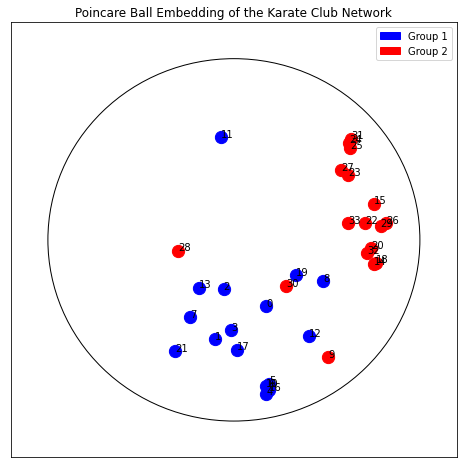

In [14]:
import matplotlib.patches as mpatches

colors = {1: 'b', 2: 'r'}
group_1 = mpatches.Patch(color=colors[1], label='Group 1')
group_2 = mpatches.Patch(color=colors[2], label='Group 2')

circle = visualization.PoincareDisk(point_type='ball')

fig, ax = plt.subplots(figsize=(8, 8))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
circle.set_ax(ax)
circle.draw(ax=ax)
for i_embedding, embedding in enumerate(embeddings):
    x = embedding[0]
    y = embedding[1]
    pt_id = i_embedding
    plt.scatter(
        x, y,
        c=colors[karate_graph.labels[pt_id][0]],
        s = 150
        )
    ax.annotate(pt_id, (x,y))

plt.tick_params(
which='both')
plt.title('Poincare Ball Embedding of the Karate Club Network')
plt.legend(handles=[group_1, group_2])
plt.show()

In [15]:
from geomstats.learning.kmeans import RiemannianKMeans

In [16]:
n_clusters = 2

In [17]:
kmeans = RiemannianKMeans(metric= hyperbolic_manifold.metric,
                          n_clusters=n_clusters,
                          init='random',
                          mean_method='batch'
                              )

In [18]:
centroids = kmeans.fit(X=embeddings)
labels = kmeans.predict(X=embeddings)

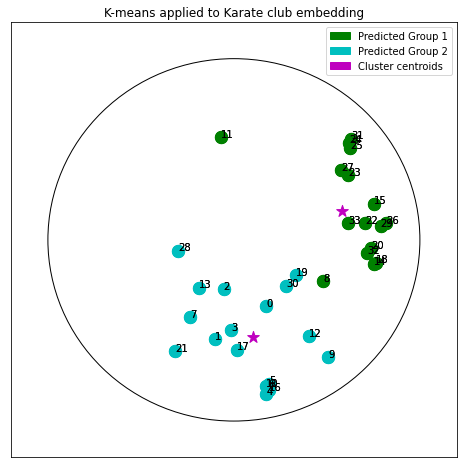

In [19]:
colors = ['g', 'c', 'm']
circle = visualization.PoincareDisk(point_type='ball')
fig2, ax2 = plt.subplots(figsize=(8, 8))
circle.set_ax(ax2)
circle.draw(ax=ax2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
group_1_predicted = mpatches.Patch(color=colors[0], label='Predicted Group 1')
group_2_predicted = mpatches.Patch(color=colors[1], label='Predicted Group 2')
group_centroids = mpatches.Patch(color=colors[2], label='Cluster centroids')

for i in range(n_clusters):
    for i_embedding, embedding in enumerate(embeddings):
        x = embedding[0]
        y = embedding[1]
        pt_id = i_embedding
        if labels[i_embedding] == 0:
            color = colors[0]
        else:
            color = colors[1]
        plt.scatter(
            x, y,
            c=color,
            s = 150
            )
        ax2.annotate(pt_id, (x,y))

for i_centroid, centroid in enumerate(centroids):
    x = centroid[0]
    y = centroid[1]
    plt.scatter(
        x, y,
        c=colors[2],
        marker='*',
        s = 150,
        )

plt.title('K-means applied to Karate club embedding')
plt.legend(handles = [group_1_predicted, group_2_predicted, group_centroids])
plt.show()